Image Classifier with Transfer Learning and CNN

In [ ]:
!pip install -U torch torchvision torchtext torchaudio --quiet
!pip install -U pytorch-lightning --quiet
!pip install opendatasets --upgrade --quiet

In [ ]:
import os,json, logging, zipfile, shutil
from pathlib import Path
import opendatasets as od, pandas as pd,  numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchmetrics.functional import accuracy
import pytorch_lightning as pl
pd.__version__, np.__version__, torch.__version__, pl.__version__

('2.2.2', '1.26.4', '2.6.0+cu124', '2.5.0.post0')

In [ ]:
from google.colab import files
files.upload()

Data processing

In [ ]:
DATA_PATH = Path('data')
KAGGLE_JSON = DATA_PATH/'kaggle.json'
IS_KAGGLE_KEY = KAGGLE_JSON.exists()
KAGGLE_API = None
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c histopathologic-cancer-detection
!unzip histopathologic-cancer-detection.zip

In [ ]:
cancer_labels = pd.read_csv('train_labels.csv')

In [ ]:
''' 0 for normal cases, 1 for abnormal '''
cancer_labels.head()[:2], cancer_labels.label.value_counts()

(                                         id  label
 0  f38a6374c348f90b587e046aac6079959adf3835      0
 1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1,
 label
 0    130908
 1     89117
 Name: count, dtype: int64)

In [ ]:
''' imgs in training/testing datasets '''
len(os.listdir('train')), len(os.listdir('test'))

(220025, 57458)

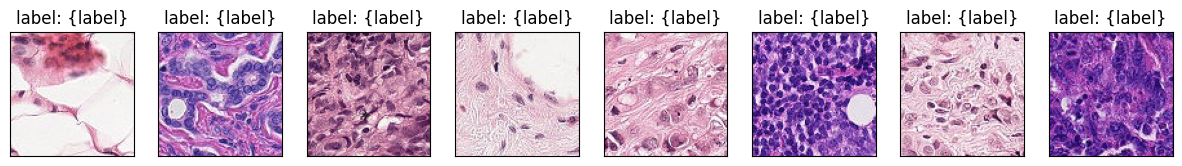

In [ ]:
np.random.seed(0)
train_imgs_lst = os.listdir('train')
selected_img_lst = []
for img in np.random.choice(train_imgs_lst, 10000):
  selected_img_lst.append(img)
fig = plt.figure(figsize=(15, 5))
for index, img in enumerate(np.random.choice(selected_img_lst, 8)):
  ax = fig.add_subplot(1, 8, index+1, xticks=[], yticks=[])
  img_n = Image.open('train/' +img)
  plt.imshow(img_n)
  label = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0],'label'].values[0]
  ax.set_title("label: {label}")

In [ ]:
np.random.seed(0)
np.random.shuffle(selected_img_lst)
cancer_train, cancer_test = selected_img_lst[:9000], selected_img_lst[9000:]
for filename in cancer_train:
  src = os.path.join('train', filename)
  dst = os.path.join('train_ds', filename)
  shutil.copyfile(src, dst)
for filename in cancer_test:
  src = os.path.join('train', filename)
  dst = os.path.join('test_ds', filename)
  shutil.copyfile(src, dst)

data_transform_train = T.Compose([
  T.CenterCrop(32), T.RandomHorizontalFlip(), T.RandomVerticalFlip(), T.ToTensor()])
data_transform_test = T.Compose([
  T.CenterCrop(32), T.RandomHorizontalFlip(), T.RandomVerticalFlip(), T.ToTensor()])

id_list, label_list = [], []
selected_img_labels=pd.DataFrame()

for img in selected_img_lst:
  label_tuple = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0]]
  id_list.append(label_tuple['id'].values[0])
  label_list.append(label_tuple['label'].values[0])

selected_img_labels['id'] = id_list
selected_img_labels['label'] = label_list
img_label_dict = {k:v for k, v in zip(selected_img_labels.id, selected_img_labels.label)}
selected_img_labels.head()[:2], #img_label_dict

(                                         id  label
 0  99d68de242bba8e13c5ff92b94a1e48f290a0c08      0
 1  26ec92d8cda18e40a966165c2962d3692db254a7      0,)

In [ ]:
class CancerDataset(Dataset):
  def __init__(self, data_folder,
               transform = T.Compose([T.CenterCrop(32),T.ToTensor()]), dict_labels={}):
    self.data_folder = data_folder
    self.list_image_files = [s for s in os.listdir(data_folder)]
    self.transform = transform
    self.dict_labels = dict_labels
    self.labels = [dict_labels[i.split('.')[0]] for i in self.list_image_files]

  def __len__(self):
    return len(self.list_image_files)

  def __getitem__(self, idx):
    img_name = os.path.join(self.data_folder, self.list_image_files[idx])
    image = Image.open(img_name)
    image = self.transform(image)
    img_name_short = self.list_image_files[idx].split('.')[0]

    label = self.dict_labels[img_name_short]
    return image, label

train_set = CancerDataset(
    data_folder='/content/train_ds/',
    transform=data_transform_train, dict_labels=img_label_dict)
test_set = CancerDataset(
    data_folder='/content/test_ds/',
    transform=data_transform_train, dict_labels=img_label_dict)

batch_size = 256

train_dataloader = DataLoader(
    train_set, batch_size, num_workers=2, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(
    test_set, batch_size, num_workers=2, pin_memory=True)


Transfer Learning

In [ ]:
from torchvision.models import resnet50
resnet50(pretrained=True)

In [ ]:
class TLImageClassifier(pl.LightningModule):
  def __init__(self, learning_rate = 0.001):
    super().__init__()

    self.learning_rate = learning_rate
    self.loss = nn.CrossEntropyLoss()
    self.pretrain_model = resnet50(pretrained=True)
    self.pretrain_model.eval()
    for param in self.pretrain_model.parameters():
      param.requires_grad = False

    self.pretrain_model.fc = nn.Linear(2048, 2)

  def forward(self, input):
    output=self.pretrain_model(input)
    return output

  def training_step(self, batch, batch_idx):
    inputs, targets = batch
    outputs = self(inputs)
    preds = torch.argmax(outputs, dim=1)
    loss = self.loss(outputs, targets)
    self.log('train_loss', loss)
    return {"loss": loss}


  def test_step(self, batch, batch_idx):
    inputs, targets = batch
    outputs = self.forward(inputs)
    loss = self.loss(outputs, targets)
    return {"test_loss": loss}

  def configure_optimizers(self):
    params = self.parameters()
    optimizer = optim.Adam(params=params, lr = self.learning_rate)
    return optimizer

In [ ]:
!mkdir transfer_learning
!chmod 775 transfer_learning

In [ ]:
model = TLImageClassifier()
trainer = pl.Trainer(fast_dev_run=True, devices=1)
trainer.fit(model, train_dataloader)
checkpoint_dir = "/content/transfer_learning"
checkpoint_callback =  pl.callbacks.ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename="epoch={epoch}-val_loss={val_loss:.2f}",  # Filename format
    monitor="val_loss",
    verbose=True,
    save_last=True,
    save_top_k=3,
    mode="min",
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type             | Params | Mode 
------------------------------------------------------------
0 | loss           | CrossEntropyLoss | 0      | train
1 | pretrain_model | ResNet           | 23.5 M | eval 
------------------------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
2         Modules in train mode
150       Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


In [ ]:
model = TLImageClassifier()
trainer = pl.Trainer(
    default_root_dir=checkpoint_dir, devices=1,
    callbacks=[checkpoint_callback],
    log_every_n_steps=30,
    max_epochs=10)

trainer.fit(model, train_dataloaders=train_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type             | Params | Mode 
------------------------------------------------------------
0 | loss           | CrossEntropyLoss | 0      | train
1 | pretrain_model | ResNet           | 23.5 M | eval 
------------------------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
2         Modules in train mode
150       Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 130: 'val_loss' was not in top 3
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 195: 'val_loss' was not in top 3
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 260: 'val_loss' was not in top 3
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 325: 'val_loss' was not in top 3
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 390: 'val_loss' was not in top 3
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 455: 'val_loss' was not in top 3
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 520: 'val_loss' was not in top 3
INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 585: 'val_loss' was not in top 3
INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 650: 'val_loss' was not in top 3
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.test(dataloaders=test_dataloader, ckpt_path='/content/transfer_learning/last.ckpt')

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/transfer_learning/last.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/transfer_learning/last.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

[{}]

In [ ]:
model.eval()
preds = []
for batch_i, (data, target) in enumerate(test_dataloader):
  target = target.cpu()
  #target = target.cuda()
  output = model(data)
  pr = output[:,1].detach().cpu().numpy()
  for i in pr:
    preds.append(i)

test_preds = pd.DataFrame({'imgs': test_set, 'labels': test_set.labels,  'preds': preds})

In [ ]:
test_preds

,imgs,labels,preds
0,"(([tensor([[1.0000, 0.7059, 0.7725, ..., 0.40...",1,-0.202027
1,"(([tensor([[1.0000, 0.7059, 0.7725, ..., 0.40...",0,-0.818039
2,"(([tensor([[0.4824, 0.5961, 0.5647, ..., 0.68...",0,0.276220
3,"(([tensor([[0.4824, 0.5961, 0.5647, ..., 0.68...",1,0.515888
4,"(([tensor([[0.3333, 0.2431, 0.4000, ..., 0.77...",1,1.422553
...,...,...,...
10631,"(([tensor([[1.0000, 0.7059, 0.7725, ..., 0.40...",1,-0.317114
10632,"(([tensor([[0.3333, 0.2431, 0.4000, ..., 0.77...",0,0.009898
10633,"(([tensor([[0.4824, 0.5961, 0.5647, ..., 0.68...",0,1.271172
10634,"(([tensor([[0.4824, 0.5961, 0.5647, ..., 0.68...",0,-1.406798


In [ ]:
#test_preds['imgs'] = test_preds['imgs'].apply(lambda x: x.split('.')[0])

In [ ]:
test_preds['predictions'] = 1
test_preds.loc[test_preds['preds'] < 0, 'predictions'] = 0
test_preds.head()

,imgs,labels,preds,predictions
0,"(([tensor([[0.7373, 0.8471, 0.6824, ..., 0.56...",1,-0.202027,0
1,"(([tensor([[1.0000, 0.7059, 0.7725, ..., 0.40...",0,-0.818039,0
2,"(([tensor([[1.0000, 0.7059, 0.7725, ..., 0.40...",0,0.276220,1
3,"(([tensor([[0.7373, 0.8471, 0.6824, ..., 0.56...",1,0.515888,1
4,"(([tensor([[1.0000, 0.7059, 0.7725, ..., 0.40...",1,1.422553,1


In [ ]:
len(np.where(test_preds['labels'] == test_preds['predictions'])[0])/test_preds.shape[0]

0.7024257239563746

Image Classifier with CNN

In [ ]:
class CNNImageClassifier(pl.LightningModule):
  def __init__(self, learning_rate = 0.001):
    super().__init__()

    self.learning_rate = learning_rate

    self.conv_layer1 = nn.Conv2d(
        in_channels = 3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2)
    self.conv_layer2 = nn.Conv2d(
        in_channels=3, out_channels=6, kernel_size=3, stride=1,padding=1)
    self.relu2 = nn.ReLU()
    self.fully_connected_1 = nn.Linear(in_features=16 * 16 * 6,out_features=1000)
    self.fully_connected_2 = nn.Linear(in_features=1000, out_features=500)
    self.fully_connected_3 = nn.Linear(in_features=500, out_features=250)
    self.fully_connected_4 = nn.Linear(in_features=250, out_features=120)
    self.fully_connected_5 = nn.Linear(in_features=120, out_features=60)
    self.fully_connected_6 = nn.Linear(in_features=60, out_features=2)
    self.loss = nn.CrossEntropyLoss()
    self.save_hyperparameters()

  def forward(self, input):
    output = self.conv_layer1(input)
    output = self.relu1(output)
    output = self.pool(output)
    output = self.conv_layer2(output)
    output = self.relu2(output)
    output = output.view(-1, 6*16*16)
    output = self.fully_connected_1(output)
    output = self.fully_connected_2(output)
    output = self.fully_connected_3(output)
    output = self.fully_connected_4(output)
    output = self.fully_connected_5(output)
    output = self.fully_connected_6(output)
    return output

  def training_step(self, batch, batch_idx):
    inputs, targets = batch
    outputs = self(inputs)
    #train_accuracy = accuracy(outputs, targets)
    loss = self.loss(outputs, targets)
    #self.log('train_accuracy', train_accuracy, prog_bar=True)
    self.log('train_loss', loss)
    #return {"loss": loss, "train_accuracy": train_accuracy}
    return {"loss": loss}

  def test_step(self, batch, batch_idx):
    inputs, targets = batch
    outputs = self.forward(inputs)
    #test_accuracy = accuracy(outputs, targets)
    loss = self.loss(outputs, targets)
    #self.log('test_accuracy', test_accuracy)
    #return {"test_loss": loss, "test_accuracy": test_accuracy}
    return {"test_loss": loss}

  def configure_optimizers(self):
    params = self.parameters()
    optimizer = optim.Adam(params=params, lr = self.learning_rate)
    return optimizer

    # Calculate accuracy for each batch at a time
  def binary_accuracy(self, outputs, targets):
    _, outputs = torch.max(outputs, 1)
    correct_results_sum = (outputs == targets).sum().float()
    accuracy = correct_results_sum/targets.shape[0]
    return accuracy

  def predict_step(self, batch, batch_idx ):
    return self(batch)

In [ ]:
device = 'cpu'
!mkdir cnn
!chmod 775 cnn

In [ ]:
next(iter(train_dataloader))

In [ ]:
model = CNNImageClassifier()
trainer = pl.Trainer(fast_dev_run=True, devices=1)
trainer.fit(model, train_dataloaders=train_dataloader)

checkpoint_dir = "/content/cnn"
checkpoint_callback = pl.callbacks.ModelCheckpoint(every_n_epochs=10)

model = CNNImageClassifier()
trainer = pl.Trainer(
    default_root_dir=checkpoint_dir,
    devices=1,
    callbacks=[checkpoint_callback],
    log_every_n_steps=25,
    max_epochs=500)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type             | Params | Mode 
----------------------------------------------------------------
0  | conv_layer1       | Conv2d           | 84     | train
1  | relu1             | ReLU             | 0      | train
2  | pool              | MaxPool2d        | 0      | train
3  | conv_layer2       | Conv2d           | 168    | train
4  | relu2             | ReLU             | 0      | train
5  | fully_connected_1 | Linear           | 1.5 M  | train
6  | fully_connected_2 | Linear           | 500 K  | train
7  | fully_c

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
model.eval()
preds = []
for batch_i, (data, target) in enumerate(test_dataloader):
  #data, target = data.cuda(), target.cuda()
  #output = model.cuda()(data)
  data, target = data.cpu(), target.cpu()
  output = model.cpu()(data)

  pr = output[:,1].detach().cpu().numpy()
  for i in pr:
    preds.append(i)

test_preds = pd.DataFrame(
  {'imgs': test_set.list_image_files, 'labels':test_set.labels, 'preds': preds})
test_preds['imgs'] = test_preds['imgs'].apply(lambda x: x.split('.')[0])
test_preds.head()

,imgs,labels,preds
0,88cc2bffb7d9f9d0c21e47861ea2f7d43cc18423,1,0.155757
1,060be8deba34b1e98e67021da6331260af270f85,0,0.155002
2,0ab60ad8fc6ed428cd3b468cf54536a818d59ee7,0,0.154894
3,d5e7cc24e0c155f4cba3cf7752c69b6b9783eea3,1,0.155302
4,1ed9e0f7c5bd1329fb5dbca6725352c58c934728,1,0.154890


In [ ]:
test_preds['predictions'] = 1
test_preds.loc[test_preds['preds'] < 0, 'predictions'] = 0
test_preds.shape

(10636, 4)

In [ ]:
test_preds.head()
len(np.where(test_preds['labels'] == test_preds['predictions'])[0])/test_preds.shape[0]

0.41152688980819857